In [1]:
! pip install torchinfo

In [2]:
import torch
import torchvision
import matplotlib.pyplot as plt
from pathlib import Path
from torchvision.transforms import ToTensor
from torchvision import transforms
from torch.utils.data import DataLoader
import os
from torch import nn
from tqdm.auto import tqdm
from torchvision import models
from torchinfo import summary

In [3]:
from torch.cuda import is_available
device = "cuda" if is_available() else "cpu"
device

'cuda'

In [4]:
def make_data(train_data, test_data, batch_size, num_workers):

    #train_data = torchvision.datasets.ImageFolder(root=train_dir_path, transform=trans)
    #test_data = torchvision.datasets.ImageFolder(root=test_dir_path, transform=trans)

    train_dataloader = DataLoader(dataset=train_data,
    batch_size=batch_size,
    shuffle=True,
    pin_memory=True,
    num_workers=num_workers)
    test_dataloader = DataLoader(dataset=test_data,
    batch_size=batch_size,
    shuffle=True,
    pin_memory=True,
    num_workers=num_workers)
    classes_names = train_data.classes

    return train_dataloader, test_dataloader, classes_names

In [5]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100
    return acc

In [6]:
def plots(train_loss_values, train_acc_values, test_loss_values, test_acc_values, train_epoch_count, test_epoch_count):
    plt.subplot(2, 1, 1)
    plt.plot(train_epoch_count, train_acc_values, c='g', label='Train Acc')
    plt.plot(train_epoch_count, test_acc_values, c='r', label='Test ACC')
    plt.title('Acc')
    plt.legend()
    plt.subplot(2, 1, 2)
    plt.plot(train_epoch_count, train_loss_values, c='blue', label="Train Loss")
    plt.plot(train_epoch_count, test_loss_values, c='orange', label="Test Loss")
    plt.title('Loss')
    plt.legend();

In [7]:
def save_model(model, MODEL_PATH, model_name):
    SAVE_PATH = MODEL_PATH / model_name
    torch.save(obj = model.state_dict(),
               f = SAVE_PATH)
    print(f"Saved to: {SAVE_PATH}")

In [8]:
def train_model(model, train_dataloader, test_dataloader, loss_fn, optimizer, accuracy_fn, epochs, device):
    train_epoch_count = []
    train_loss_values = []
    train_acc_values = []
    test_epoch_count = []
    test_loss_values = []
    test_acc_values = []
    #epochs = 10
    for epoch in tqdm(range(epochs)):
        # Train Block
        ls_loss = 0
        ls_acc = 0

        model.train()

        for batch, (X, y) in enumerate(train_dataloader):
            X, y = X.to(device), y.to(device)
            #y = y.type(torch.long)

            logits = model(X).squeeze()
            preds = torch.argmax(torch.softmax(logits, dim=1),dim=1)
            #print(X.shape, y.shape, logits.shape)
            loss = loss_fn(logits, y)
            acc = accuracy_fn(y_true = y, y_pred = preds)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            ls_loss += loss.item()
            ls_acc += acc
            if batch % 400 == 0:
                print(f"Epoch: {epoch+1} | Batch: {batch}...")
        mean_loss = ls_loss / len(train_dataloader)
        mean_acc = ls_acc / len(train_dataloader)
        train_loss_values.append(loss.item())
        train_acc_values.append(acc)
        train_epoch_count.append(epoch+1)
        print(f"Epoch: {epoch+1} | Loss: {mean_loss:.4f} | Acc: {mean_acc:.2f}%")


        # Test Block
        ls_loss, ls_acc = 0, 0

        model.eval()

        for batch, (X, y) in enumerate(test_dataloader):
            with torch.inference_mode():
                X, y = X.to(device), y.to(device)
                #y = y.type(torch.long)
                mean_loss, mean_acc = 0, 0
                logits = model(X).squeeze()
                preds = torch.argmax(torch.softmax(logits, dim=1),dim=1)
                loss = loss_fn(logits, y)
                acc = accuracy_fn(y_true = y,y_pred = preds)
                ls_loss += loss.item()
                ls_acc += acc
                if batch % 300 == 0:
                    print(f"TEST :    Epoch: {epoch+1} | Batch: {batch}...")
        mean_loss = ls_loss / len(test_dataloader)
        mean_acc = ls_acc / len(test_dataloader)
        test_loss_values.append(loss.item())
        test_acc_values.append(acc)
        test_epoch_count.append(epoch+1)
        print(f"TEST :    Epoch: {epoch+1} | Loss: {mean_loss:.4f} | Acc: {mean_acc:.2f}%\n\n")
    return train_loss_values, train_acc_values, test_loss_values, test_acc_values, train_epoch_count, test_epoch_count

In [9]:
from torchvision.datasets import Food101
loss_fn = nn.CrossEntropyLoss()

# шаблон

# Новый раздел

In [ ]:
weights = models.EfficientNet_B0_Weights.DEFAULT
auto_transform = weights.transforms()

train_data = Food101(root="data/train",
                     split="train",
                     download=True,
                     transform=                  auto_transform)
test_data = Food101(root="data/test",
                     split="test",
                     download=True,
                     transform=                  auto_transform)

cpu_c = os.cpu_count()
BATCH_SIZE = 32
train_dataloader, test_dataloader, classes_names = make_data(train_data, test_data, batch_size=BATCH_SIZE, num_workers=cpu_c)
train_dataloader, test_dataloader, classes_names[:10]


In [ ]:
MODEL_PATH_BOBAV0_efficientnet_b0_SGD = Path("E:/CODING/projectBoBa/transfer_models")
MODEL_NAME_BOBAV0_efficientnet_b0_SGD = "BOBAV0_efficientnet_b0_SGDSecond.pth"
MODEL_PATH_BOBAV0_efficientnet_b0_SGD / MODEL_NAME_BOBAV0_efficientnet_b0_SGD
save_model(BobaV0_efficientnetb0, MODEL_PATH_BOBAV0_efficientnet_b0_SGD, MODEL_NAME_BOBAV0_efficientnet_b0_SGD)

In [ ]:
optimizer = torch.optim.Adam(Boba_V1_efficientnet_b1_Adam.parameters(),
                              lr=0.01)
train_loss_valuesV2, train_acc_valuesV2, test_loss_valuesV2, test_acc_valuesV2, train_epoch_countV2, test_epoch_countV2 = train_model(
    model=Boba_V1_efficientnet_b1_Adam, train_dataloader=train_dataloader, test_dataloader=test_dataloader,
            optimizer=optimizer, loss_fn=loss_fn ,accuracy_fn=accuracy_fn, epochs=10, device=device)

# GoogleNet

In [ ]:
GoogleNet_weights = models.GoogLeNet_Weights.DEFAULT
auto_transform = GoogleNet_weights.transforms()

train_data = Food101(root="data/train",
                     split="train",
                     download=True,
                     transform=                  auto_transform)
test_data = Food101(root="data/test",
                     split="test",
                     download=True,
                     transform=                  auto_transform)

cpu_c = os.cpu_count()
BATCH_SIZE = 32
train_dataloader, test_dataloader, classes_names = make_data(train_data, test_data, batch_size=BATCH_SIZE, num_workers=cpu_c)
train_dataloader, test_dataloader, classes_names[:10], auto_transform

(<torch.utils.data.dataloader.DataLoader at 0x19110772150>,
 ['apple_pie',
  'baby_back_ribs',
  'baklava',
  'beef_carpaccio',
  'beef_tartare',
  'beet_salad',
  'beignets',
  'bibimbap',
  'bread_pudding',
  'breakfast_burrito'],
 ImageClassification(
     crop_size=[224]
     resize_size=[256]
     mean=[0.485, 0.456, 0.406]
     std=[0.229, 0.224, 0.225]
     interpolation=InterpolationMode.BILINEAR
 ))

In [ ]:
Model_GoogleNet = models.googlenet(weights=GoogleNet_weights).to(device)

In [ ]:
Model_GoogleNet

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [ ]:
Model_GoogleNet.fc = nn.Linear(in_features=1024, out_features=101, bias=True).to(device)
Model_GoogleNet

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [ ]:
summary(model=Model_GoogleNet,input_size=(32, 3, 256, 256),col_names=['input_size', 'output_size',"num_params", 'trainable'],col_width=20,row_settings=['var_names'])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
GoogLeNet (GoogLeNet)                    [32, 3, 256, 256]    [32, 101]            --                   True
├─BasicConv2d (conv1)                    [32, 3, 256, 256]    [32, 64, 128, 128]   --                   True
│    └─Conv2d (conv)                     [32, 3, 256, 256]    [32, 64, 128, 128]   9,408                True
│    └─BatchNorm2d (bn)                  [32, 64, 128, 128]   [32, 64, 128, 128]   128                  True
├─MaxPool2d (maxpool1)                   [32, 64, 128, 128]   [32, 64, 64, 64]     --                   --
├─BasicConv2d (conv2)                    [32, 64, 64, 64]     [32, 64, 64, 64]     --                   True
│    └─Conv2d (conv)                     [32, 64, 64, 64]     [32, 64, 64, 64]     4,096                True
│    └─BatchNorm2d (bn)                  [32, 64, 64, 64]     [32, 64, 64, 64]     128                  True
├─BasicConv2d (c

In [ ]:
for param in Model_GoogleNet.parameters():
    param.requires_grad = False
summary(model=Model_GoogleNet,input_size=(32, 3, 256, 256),col_names=['input_size', 'output_size',"num_params", 'trainable'],col_width=20,row_settings=['var_names'])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
GoogLeNet (GoogLeNet)                    [32, 3, 256, 256]    [32, 101]            --                   False
├─BasicConv2d (conv1)                    [32, 3, 256, 256]    [32, 64, 128, 128]   --                   False
│    └─Conv2d (conv)                     [32, 3, 256, 256]    [32, 64, 128, 128]   (9,408)              False
│    └─BatchNorm2d (bn)                  [32, 64, 128, 128]   [32, 64, 128, 128]   (128)                False
├─MaxPool2d (maxpool1)                   [32, 64, 128, 128]   [32, 64, 64, 64]     --                   --
├─BasicConv2d (conv2)                    [32, 64, 64, 64]     [32, 64, 64, 64]     --                   False
│    └─Conv2d (conv)                     [32, 64, 64, 64]     [32, 64, 64, 64]     (4,096)              False
│    └─BatchNorm2d (bn)                  [32, 64, 64, 64]     [32, 64, 64, 64]     (128)                False
├─BasicCo

In [ ]:
for param in Model_GoogleNet.fc.parameters():
    param.requires_grad = True
summary(model=Model_GoogleNet,input_size=(32, 3, 256, 256),col_names=['input_size', 'output_size',"num_params", 'trainable'],col_width=20,row_settings=['var_names'])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
GoogLeNet (GoogLeNet)                    [32, 3, 256, 256]    [32, 101]            --                   Partial
├─BasicConv2d (conv1)                    [32, 3, 256, 256]    [32, 64, 128, 128]   --                   False
│    └─Conv2d (conv)                     [32, 3, 256, 256]    [32, 64, 128, 128]   (9,408)              False
│    └─BatchNorm2d (bn)                  [32, 64, 128, 128]   [32, 64, 128, 128]   (128)                False
├─MaxPool2d (maxpool1)                   [32, 64, 128, 128]   [32, 64, 64, 64]     --                   --
├─BasicConv2d (conv2)                    [32, 64, 64, 64]     [32, 64, 64, 64]     --                   False
│    └─Conv2d (conv)                     [32, 64, 64, 64]     [32, 64, 64, 64]     (4,096)              False
│    └─BatchNorm2d (bn)                  [32, 64, 64, 64]     [32, 64, 64, 64]     (128)                False
├─Basic

In [ ]:
optimizerGooglenet = torch.optim.SGD(Model_GoogleNet.parameters(),
                              lr=0.01)
train_loss_values_Googlenet, train_acc_values_Googlenet, test_loss_values_Googlenet, test_acc_values_Googlenet, train_epoch_count_Googlenet, test_epoch_count_Googlenet = train_model(
    model=Model_GoogleNet, train_dataloader=train_dataloader, test_dataloader=test_dataloader,
            optimizer=optimizerGooglenet, loss_fn=loss_fn ,accuracy_fn=accuracy_fn, epochs=10, device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | Batch: 0...
Epoch: 1 | Batch: 400...
Epoch: 1 | Batch: 800...
Epoch: 1 | Batch: 1200...
Epoch: 1 | Batch: 1600...
Epoch: 1 | Batch: 2000...
Epoch: 1 | Loss: 3.9939 | Acc: 20.58%
TEST :    Epoch: 1 | Batch: 0...
TEST :    Epoch: 1 | Batch: 300...
TEST :    Epoch: 1 | Batch: 600...
TEST :    Epoch: 1 | Loss: 3.3496 | Acc: 36.78%


Epoch: 2 | Batch: 0...
Epoch: 2 | Batch: 400...
Epoch: 2 | Batch: 800...
Epoch: 2 | Batch: 1200...
Epoch: 2 | Batch: 1600...
Epoch: 2 | Batch: 2000...
Epoch: 2 | Loss: 3.1963 | Acc: 34.87%
TEST :    Epoch: 2 | Batch: 0...
TEST :    Epoch: 2 | Batch: 300...
TEST :    Epoch: 2 | Batch: 600...
TEST :    Epoch: 2 | Loss: 2.7726 | Acc: 42.59%


Epoch: 3 | Batch: 0...
Epoch: 3 | Batch: 400...
Epoch: 3 | Batch: 800...
Epoch: 3 | Batch: 1200...
Epoch: 3 | Batch: 1600...
Epoch: 3 | Batch: 2000...
Epoch: 3 | Loss: 2.8369 | Acc: 38.70%
TEST :    Epoch: 3 | Batch: 0...
TEST :    Epoch: 3 | Batch: 300...
TEST :    Epoch: 3 | Batch: 600...
TEST :    Epoch: 3 | Los

In [ ]:
MODEL_PATH_BOBA_Googlenet = Path("E:/CODING/projectBoBa/transfer_models")
MODEL_NAME_BOBA_Googlenet = "BOBA_Googlenet.pth"
MODEL_PATH_BOBA_Googlenet / MODEL_NAME_BOBA_Googlenet
save_model(Model_GoogleNet, MODEL_PATH_BOBA_Googlenet, MODEL_NAME_BOBA_Googlenet)

Saved to: E:\CODING\projectBoBa\transfer_models\BOBA_Googlenet.pth


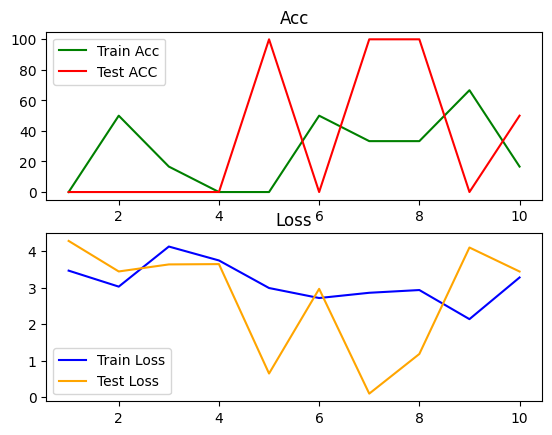

In [ ]:
plots(train_loss_values_Googlenet, train_acc_values_Googlenet, test_loss_values_Googlenet, test_acc_values_Googlenet, train_epoch_count_Googlenet, test_epoch_count_Googlenet)

# EfficientnetV0

In [ ]:
EfficientNet_b0_weights = models.EfficientNet_B0_Weights.DEFAULT
auto_transform = weights.transforms()

train_data = Food101(root="data/train",
                     split="train",
                     download=True,
                     transform=                  auto_transform)
test_data = Food101(root="data/test",
                     split="test",
                     download=True,
                     transform=                  auto_transform)

cpu_c = os.cpu_count()
BATCH_SIZE = 32
train_dataloader, test_dataloader, classes_names = make_data(train_data, test_data, batch_size=BATCH_SIZE, num_workers=cpu_c)
train_dataloader, test_dataloader, classes_names[:10]


(<torch.utils.data.dataloader.DataLoader at 0x1911f157350>,
 ['apple_pie',
  'baby_back_ribs',
  'baklava',
  'beef_carpaccio',
  'beef_tartare',
  'beet_salad',
  'beignets',
  'bibimbap',
  'bread_pudding',
  'breakfast_burrito'])

In [ ]:
Model_EfficientNet_b0 = models.efficientnet_b0(weights=EfficientNet_b0_weights).to(device)
Model_EfficientNet_b0

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [ ]:
Model_EfficientNet_b0.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=101, bias=True)
).to(device)

In [ ]:
Model_EfficientNet_b0

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [ ]:
for param in Model_EfficientNet_b0.features.parameters():
    param.requires_grad = False

In [ ]:
summary(model=Model_EfficientNet_b0,input_size=(32, 3, 256, 256),col_names=['input_size', 'output_size',"num_params", 'trainable'],col_width=20,row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 256, 256]    [32, 101]            --                   Partial
├─Sequential (features)                                      [32, 3, 256, 256]    [32, 1280, 8, 8]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 256, 256]    [32, 32, 128, 128]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 256, 256]    [32, 32, 128, 128]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 128, 128]   [32, 32, 128, 128]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 128, 128]   [32, 32, 128, 128]   --                   --
│    └─Sequential (1)                                        [32, 32, 128, 128]   [32, 

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | Batch: 0...
Epoch: 1 | Batch: 400...
Epoch: 1 | Batch: 800...
Epoch: 1 | Batch: 1200...
Epoch: 1 | Batch: 1600...
Epoch: 1 | Batch: 2000...
Epoch: 1 | Loss: 3.9394 | Acc: 25.04%
TEST :    Epoch: 1 | Batch: 0...
TEST :    Epoch: 1 | Batch: 300...
TEST :    Epoch: 1 | Batch: 600...
TEST :    Epoch: 1 | Loss: 3.2544 | Acc: 42.33%


Epoch: 2 | Batch: 0...
Epoch: 2 | Batch: 400...
Epoch: 2 | Batch: 800...
Epoch: 2 | Batch: 1200...
Epoch: 2 | Batch: 1600...
Epoch: 2 | Batch: 2000...
Epoch: 2 | Loss: 3.0837 | Acc: 39.98%
TEST :    Epoch: 2 | Batch: 0...
TEST :    Epoch: 2 | Batch: 300...
TEST :    Epoch: 2 | Batch: 600...
TEST :    Epoch: 2 | Loss: 2.6099 | Acc: 48.41%


Epoch: 3 | Batch: 0...
Epoch: 3 | Batch: 400...
Epoch: 3 | Batch: 800...
Epoch: 3 | Batch: 1200...
Epoch: 3 | Batch: 1600...
Epoch: 3 | Batch: 2000...
Epoch: 3 | Loss: 2.6976 | Acc: 43.53%
TEST :    Epoch: 3 | Batch: 0...
TEST :    Epoch: 3 | Batch: 300...
TEST :    Epoch: 3 | Batch: 600...
TEST :    Epoch: 3 | Los

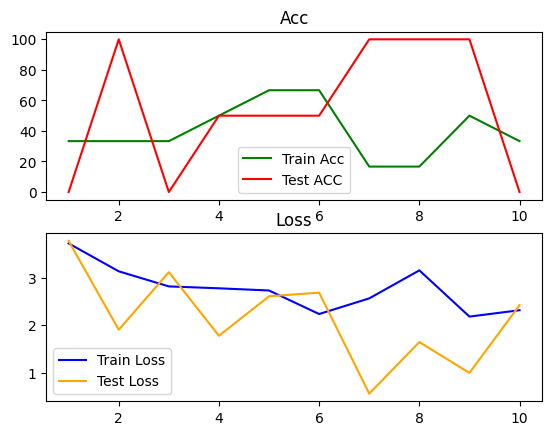

In [ ]:
optimizer = torch.optim.SGD(Model_EfficientNet_b0.parameters(),
                              lr=0.01)
train_loss_values_EfficientNet_b0, train_acc_values_EfficientNet_b0, test_loss_values_EfficientNet_b0, test_acc_values_EfficientNet_b0, train_epoch_count_EfficientNet_b0, test_epoch_count_EfficientNet_b0 = train_model(
    model=Model_EfficientNet_b0, train_dataloader=train_dataloader, test_dataloader=test_dataloader,
            optimizer=optimizer, loss_fn=loss_fn ,accuracy_fn=accuracy_fn, epochs=10, device=device)
plots(train_loss_values_EfficientNet_b0, train_acc_values_EfficientNet_b0, test_loss_values_EfficientNet_b0, test_acc_values_EfficientNet_b0, train_epoch_count_EfficientNet_b0, test_epoch_count_EfficientNet_b0)

In [ ]:
MODEL_PATH_BOBA_Efficientnet_b0 = Path("E:/CODING/projectBoBa/transfer_models")
MODEL_NAME_BOBA_Efficientnet_b0 = "BOBA_Efficientnet_b0.pth"
MODEL_PATH_BOBA_Efficientnet_b0 / MODEL_NAME_BOBA_Efficientnet_b0
save_model(Model_EfficientNet_b0, MODEL_PATH_BOBA_Efficientnet_b0, MODEL_NAME_BOBA_Efficientnet_b0)

Saved to: E:\CODING\projectBoBa\transfer_models\BOBA_Efficientnet_b0.pth


# EfficientnetV1

In [ ]:
EfficientNet_b1_weights = models.EfficientNet_B1_Weights.DEFAULT
auto_transform = EfficientNet_b1_weights.transforms()

train_data = Food101(root="data/train",
                     split="train",
                     download=True,
                     transform=                  auto_transform)
test_data = Food101(root="data/test",
                     split="test",
                     download=True,
                     transform=                  auto_transform)

cpu_c = os.cpu_count()
BATCH_SIZE = 32
train_dataloader, test_dataloader, classes_names = make_data(train_data, test_data, batch_size=BATCH_SIZE, num_workers=cpu_c)
train_dataloader, test_dataloader, classes_names[:10], auto_transform

(<torch.utils.data.dataloader.DataLoader at 0x19126b5d350>,
 ['apple_pie',
  'baby_back_ribs',
  'baklava',
  'beef_carpaccio',
  'beef_tartare',
  'beet_salad',
  'beignets',
  'bibimbap',
  'bread_pudding',
  'breakfast_burrito'],
 ImageClassification(
     crop_size=[240]
     resize_size=[255]
     mean=[0.485, 0.456, 0.406]
     std=[0.229, 0.224, 0.225]
     interpolation=InterpolationMode.BILINEAR
 ))

In [ ]:
Model_EfficientNet_b1 = models.efficientnet_b1(weights=EfficientNet_b1_weights).to(device)
Model_EfficientNet_b1

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [ ]:
Model_EfficientNet_b1.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=101, bias=True)
  ).to(device)
Model_EfficientNet_b1

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [ ]:
for param in Model_EfficientNet_b1.features.parameters():
    param.requires_grad = False
summary(model=Model_EfficientNet_b1,input_size=(32, 3, 256, 256),col_names=['input_size', 'output_size',"num_params", 'trainable'],col_width=20,row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 256, 256]    [32, 101]            --                   Partial
├─Sequential (features)                                      [32, 3, 256, 256]    [32, 1280, 8, 8]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 256, 256]    [32, 32, 128, 128]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 256, 256]    [32, 32, 128, 128]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 128, 128]   [32, 32, 128, 128]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 128, 128]   [32, 32, 128, 128]   --                   --
│    └─Sequential (1)                                        [32, 32, 128, 128]   [32, 

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | Batch: 0...
Epoch: 1 | Batch: 400...
Epoch: 1 | Batch: 800...
Epoch: 1 | Batch: 1200...
Epoch: 1 | Batch: 1600...
Epoch: 1 | Batch: 2000...
Epoch: 1 | Loss: 4.4255 | Acc: 18.43%
TEST :    Epoch: 1 | Batch: 0...
TEST :    Epoch: 1 | Batch: 300...
TEST :    Epoch: 1 | Batch: 600...
TEST :    Epoch: 1 | Loss: 4.2021 | Acc: 37.04%


Epoch: 2 | Batch: 0...
Epoch: 2 | Batch: 400...
Epoch: 2 | Batch: 800...
Epoch: 2 | Batch: 1200...
Epoch: 2 | Batch: 1600...
Epoch: 2 | Batch: 2000...
Epoch: 2 | Loss: 4.0678 | Acc: 35.00%
TEST :    Epoch: 2 | Batch: 0...
TEST :    Epoch: 2 | Batch: 300...
TEST :    Epoch: 2 | Batch: 600...
TEST :    Epoch: 2 | Loss: 3.8390 | Acc: 42.88%


Epoch: 3 | Batch: 0...
Epoch: 3 | Batch: 400...
Epoch: 3 | Batch: 800...
Epoch: 3 | Batch: 1200...
Epoch: 3 | Batch: 1600...
Epoch: 3 | Batch: 2000...
Epoch: 3 | Loss: 3.7636 | Acc: 39.18%
TEST :    Epoch: 3 | Batch: 0...
TEST :    Epoch: 3 | Batch: 300...
TEST :    Epoch: 3 | Batch: 600...
TEST :    Epoch: 3 | Los

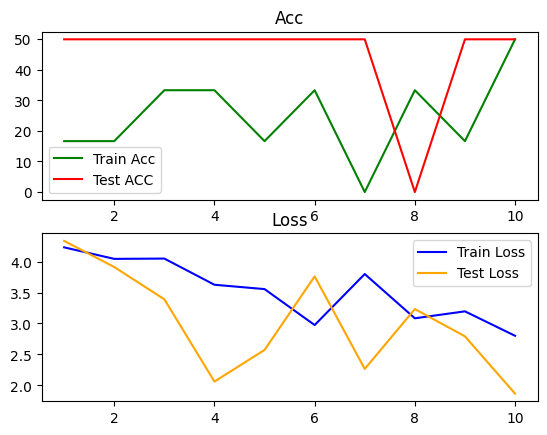

In [ ]:
optimizer = torch.optim.SGD(Model_EfficientNet_b1.parameters(),
                              lr=0.01)

train_loss_values_EfficientNet_b1, train_acc_values_EfficientNet_b1, test_loss_values_EfficientNet_b1, test_acc_values_EfficientNet_b1, train_epoch_count_EfficientNet_b1, test_epoch_count_EfficientNet_b1 = train_model(
    model=Model_EfficientNet_b1, train_dataloader=train_dataloader, test_dataloader=test_dataloader,
            optimizer=optimizer, loss_fn=loss_fn ,accuracy_fn=accuracy_fn, epochs=10, device=device)

plots(train_loss_values_EfficientNet_b1, train_acc_values_EfficientNet_b1, test_loss_values_EfficientNet_b1, test_acc_values_EfficientNet_b1, train_epoch_count_EfficientNet_b1, test_epoch_count_EfficientNet_b1)

In [ ]:
MODEL_PATH_BOBA_Efficientnet_b1 = Path("E:/CODING/projectBoBa/transfer_models")
MODEL_NAME_BOBA_Efficientnet_b1 = "BOBA_Efficientnet_b1.pth"
MODEL_PATH_BOBA_Efficientnet_b1 / MODEL_NAME_BOBA_Efficientnet_b1
save_model(Model_EfficientNet_b1, MODEL_PATH_BOBA_Efficientnet_b1, MODEL_NAME_BOBA_Efficientnet_b1)

Saved to: E:\CODING\projectBoBa\transfer_models\BOBA_Efficientnet_b1.pth


# EfficientnetV2

In [ ]:
GoogleNet_weights = models.GoogLeNet_Weights.DEFAULT
auto_transform = GoogleNet_weights.transforms()

train_data = Food101(root="data/train",
                     split="train",
                     download=True,
                     transform=                  auto_transform)
test_data = Food101(root="data/test",
                     split="test",
                     download=True,
                     transform=                  auto_transform)

cpu_c = os.cpu_count()
BATCH_SIZE = 32
train_dataloader, test_dataloader, classes_names = make_data(train_data, test_data, batch_size=BATCH_SIZE, num_workers=cpu_c)
train_dataloader, test_dataloader, classes_names[:10], auto_transform

In [ ]:
optimizer = torch.optim.SGD(Model_EfficientNet_b0.parameters(),
                              lr=0.01)
train_loss_values_EfficientNet_b0, train_acc_values_EfficientNet_b0, test_loss_values_EfficientNet_b0, test_acc_values_EfficientNet_b0, train_epoch_count_EfficientNet_b0, test_epoch_count_EfficientNet_b0 = train_model(
    model=Model_EfficientNet_b0, train_dataloader=train_dataloader, test_dataloader=test_dataloader,
            optimizer=optimizer, loss_fn=loss_fn ,accuracy_fn=accuracy_fn, epochs=10, device=device)
plots(train_loss_values_EfficientNet_b0, train_acc_values_EfficientNet_b0, test_loss_values_EfficientNet_b0, test_acc_values_EfficientNet_b0, train_epoch_count_EfficientNet_b0, test_epoch_count_EfficientNet_b0)

# ViT_b_16

In [ ]:
ViT_b_16_weights = models.ViT_B_16_Weights.DEFAULT
auto_transform = ViT_b_16_weights.transforms()

train_data = Food101(root="data/train",
                     split="train",
                     download=True,
                     transform=                  auto_transform)
test_data = Food101(root="data/test",
                     split="test",
                     download=True,
                     transform=                  auto_transform)

cpu_c = os.cpu_count()
BATCH_SIZE = 32
train_dataloader, test_dataloader, classes_names = make_data(train_data, test_data, batch_size=BATCH_SIZE, num_workers=cpu_c)
train_dataloader, test_dataloader, classes_names[:10], auto_transform

100%|██████████| 5.00G/5.00G [03:19<00:00, 25.1MB/s]
100%|██████████| 5.00G/5.00G [03:59<00:00, 20.9MB/s]


(<torch.utils.data.dataloader.DataLoader at 0x7d42062e0650>,
 ['apple_pie',
  'baby_back_ribs',
  'baklava',
  'beef_carpaccio',
  'beef_tartare',
  'beet_salad',
  'beignets',
  'bibimbap',
  'bread_pudding',
  'breakfast_burrito'],
 ImageClassification(
     crop_size=[224]
     resize_size=[256]
     mean=[0.485, 0.456, 0.406]
     std=[0.229, 0.224, 0.225]
     interpolation=InterpolationMode.BILINEAR
 ))

In [ ]:
ViT_b_16 = torch.load("/content/model_1213/second_model_TiV_16_b.pth", weights_only=False).to(device)
ViT_b_16

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [ ]:
summary(model=ViT_b_16,input_size=(32, 3, 224, 224),col_names=['input_size', 'output_size',"num_params", 'trainable'],col_width=20,row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 101]            768                  True
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              True
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   True
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       7,087,872            True
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 197, 76

In [ ]:
for params in ViT_b_16.encoder.parameters():
        params.requires_grad=False

for params in ViT_b_16.conv_proj.parameters():
        params.requires_grad=False



for param in ViT_b_16.heads.parameters():
        param.requires_grad = True

In [ ]:
summary(model=ViT_b_16,input_size=(32, 3, 224, 224),col_names=['input_size', 'output_size',"num_params", 'trainable'],col_width=20,row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 101]            768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

In [ ]:
loaded_ViT_b_16 = torch.load("/content/premodels/ViT_b_16_model.pth", weights_only=False)
loaded_ViT_b_16.to(device)

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [ ]:
for params in loaded_ViT_b_16.encoder.parameters():
        params.requires_grad=False

for params in loaded_ViT_b_16.conv_proj.parameters():
        params.requires_grad=False


for param in loaded_ViT_b_16.heads.parameters():
        param.requires_grad = True

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 1 | Batch: 0...
Epoch: 1 | Batch: 400...
Epoch: 1 | Batch: 800...
Epoch: 1 | Batch: 1200...
Epoch: 1 | Batch: 1600...
Epoch: 1 | Batch: 2000...
Epoch: 1 | Loss: 0.8640 | Acc: 77.79%
TEST :    Epoch: 1 | Batch: 0...
TEST :    Epoch: 1 | Batch: 300...
TEST :    Epoch: 1 | Batch: 600...
TEST :    Epoch: 1 | Loss: 0.8018 | Acc: 78.61%




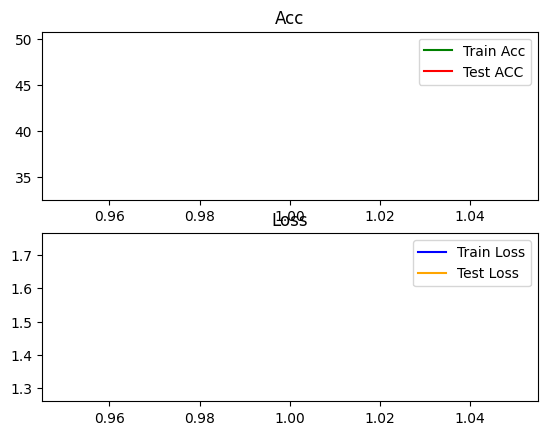

In [ ]:
optimizer = torch.optim.SGD(ViT_b_16.parameters(),
                              lr=0.01)

train_loss_values_ViT_b_16, train_acc_values_ViT_b_16, test_loss_values_ViT_b_16, test_acc_values_ViT_b_16, train_epoch_count_ViT_b_16, test_epoch_count_ViT_b_16 = train_model(
    model=ViT_b_16, train_dataloader=train_dataloader, test_dataloader=test_dataloader,
            optimizer=optimizer, loss_fn=loss_fn ,accuracy_fn=accuracy_fn, epochs=1, device=device)

plots(train_loss_values_ViT_b_16, train_acc_values_ViT_b_16, test_loss_values_ViT_b_16, test_acc_values_ViT_b_16, train_epoch_count_ViT_b_16, test_epoch_count_ViT_b_16)

In [ ]:
MODEL_PATH_vIT_AFTER_5EPOCHS = Path("/content/transfer_learnin_models")
MODEL_NAME_vIT_AFTER_5EPOCHS = "vIT_AFTER_5EPOCHS_dict.pth"
MODEL_PATH_vIT_AFTER_5EPOCHS / MODEL_NAME_vIT_AFTER_5EPOCHS
save_model(loaded_ViT_b_16, MODEL_PATH_vIT_AFTER_5EPOCHS, MODEL_NAME_vIT_AFTER_5EPOCHS)

RuntimeError: Parent directory /content/transfer_learnin_models does not exist.

In [ ]:
torch.save(ViT_b_16, "/content/tran_models/ViT_b_16_model_AFTER5_2.pth")

# EfficientnetV2_s

In [ ]:
GoogleNet_weights = models.GoogLeNet_Weights.DEFAULT
auto_transform = GoogleNet_weights.transforms()

train_data = Food101(root="data/train",
                     split="train",
                     download=True,
                     transform=                  auto_transform)
test_data = Food101(root="data/test",
                     split="test",
                     download=True,
                     transform=                  auto_transform)

cpu_c = os.cpu_count()
BATCH_SIZE = 32
train_dataloader, test_dataloader, classes_names = make_data(train_data, test_data, batch_size=BATCH_SIZE, num_workers=cpu_c)
train_dataloader, test_dataloader, classes_names[:10], auto_transform

In [ ]:
optimizer = torch.optim.SGD(Model_EfficientNet_b0.parameters(),
                              lr=0.01)
train_loss_values_EfficientNet_b0, train_acc_values_EfficientNet_b0, test_loss_values_EfficientNet_b0, test_acc_values_EfficientNet_b0, train_epoch_count_EfficientNet_b0, test_epoch_count_EfficientNet_b0 = train_model(
    model=Model_EfficientNet_b0, train_dataloader=train_dataloader, test_dataloader=test_dataloader,
            optimizer=optimizer, loss_fn=loss_fn ,accuracy_fn=accuracy_fn, epochs=10, device=device)
plots(train_loss_values_EfficientNet_b0, train_acc_values_EfficientNet_b0, test_loss_values_EfficientNet_b0, test_acc_values_EfficientNet_b0, train_epoch_count_EfficientNet_b0, test_epoch_count_EfficientNet_b0)

# MobileNet_v2

In [ ]:
GoogleNet_weights = models.GoogLeNet_Weights.DEFAULT
auto_transform = GoogleNet_weights.transforms()

train_data = Food101(root="data/train",
                     split="train",
                     download=True,
                     transform=                  auto_transform)
test_data = Food101(root="data/test",
                     split="test",
                     download=True,
                     transform=                  auto_transform)

cpu_c = os.cpu_count()
BATCH_SIZE = 32
train_dataloader, test_dataloader, classes_names = make_data(train_data, test_data, batch_size=BATCH_SIZE, num_workers=cpu_c)
train_dataloader, test_dataloader, classes_names[:10], auto_transform

In [ ]:
optimizer = torch.optim.SGD(Model_EfficientNet_b0.parameters(),
                              lr=0.01)
train_loss_values_EfficientNet_b0, train_acc_values_EfficientNet_b0, test_loss_values_EfficientNet_b0, test_acc_values_EfficientNet_b0, train_epoch_count_EfficientNet_b0, test_epoch_count_EfficientNet_b0 = train_model(
    model=Model_EfficientNet_b0, train_dataloader=train_dataloader, test_dataloader=test_dataloader,
            optimizer=optimizer, loss_fn=loss_fn ,accuracy_fn=accuracy_fn, epochs=10, device=device)
plots(train_loss_values_EfficientNet_b0, train_acc_values_EfficientNet_b0, test_loss_values_EfficientNet_b0, test_acc_values_EfficientNet_b0, train_epoch_count_EfficientNet_b0, test_epoch_count_EfficientNet_b0)

# ShuffleNetV2


In [ ]:
ShuffleNet_V2_X2_0_weights = models.ShuffleNet_V2_X2_0_Weights.DEFAULT
auto_transform = ShuffleNet_V2_X2_0_weights.transforms()

train_data = Food101(root="data/train",
                     split="train",
                     download=True,
                     transform=                  auto_transform)
test_data = Food101(root="data/test",
                     split="test",
                     download=True,
                     transform=                  auto_transform)

cpu_c = os.cpu_count()
BATCH_SIZE = 32
train_dataloader, test_dataloader, classes_names = make_data(train_data, test_data, batch_size=BATCH_SIZE, num_workers=cpu_c)
train_dataloader, test_dataloader, classes_names[:10], auto_transform

100%|██████████| 5.00G/5.00G [02:38<00:00, 31.6MB/s]
100%|██████████| 5.00G/5.00G [02:51<00:00, 29.2MB/s]


(<torch.utils.data.dataloader.DataLoader at 0x7d728b6e0650>,
 ['apple_pie',
  'baby_back_ribs',
  'baklava',
  'beef_carpaccio',
  'beef_tartare',
  'beet_salad',
  'beignets',
  'bibimbap',
  'bread_pudding',
  'breakfast_burrito'],
 ImageClassification(
     crop_size=[224]
     resize_size=[232]
     mean=[0.485, 0.456, 0.406]
     std=[0.229, 0.224, 0.225]
     interpolation=InterpolationMode.BILINEAR
 ))

In [ ]:
Model_ShuffleNet_V2_X2_0 = models.shufflenet_v2_x2_0(weights=ShuffleNet_V2_X2_0_weights).to(device)
Model_ShuffleNet_V2_X2_0

Downloading: "https://download.pytorch.org/models/shufflenetv2_x2_0-8be3c8ee.pth" to /root/.cache/torch/hub/checkpoints/shufflenetv2_x2_0-8be3c8ee.pth
100%|██████████| 28.4M/28.4M [00:00<00:00, 80.1MB/s]


ShuffleNetV2(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): InvertedResidual(
      (branch1): Sequential(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(24, 122, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(122, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
      )
      (branch2): Sequential(
        (0): Conv2d(24, 122, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(122, eps=1e-05, momentum=0.1, affine=True, track_runn

In [ ]:
summary(model=Model_ShuffleNet_V2_X2_0,input_size=(32, 3, 256, 256),col_names=['input_size', 'output_size',"num_params", 'trainable'],col_width=20,row_settings=['var_names'])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ShuffleNetV2 (ShuffleNetV2)              [32, 3, 256, 256]    [32, 1000]           --                   True
├─Sequential (conv1)                     [32, 3, 256, 256]    [32, 24, 128, 128]   --                   True
│    └─Conv2d (0)                        [32, 3, 256, 256]    [32, 24, 128, 128]   648                  True
│    └─BatchNorm2d (1)                   [32, 24, 128, 128]   [32, 24, 128, 128]   48                   True
│    └─ReLU (2)                          [32, 24, 128, 128]   [32, 24, 128, 128]   --                   --
├─MaxPool2d (maxpool)                    [32, 24, 128, 128]   [32, 24, 64, 64]     --                   --
├─Sequential (stage2)                    [32, 24, 64, 64]     [32, 244, 32, 32]    --                   True
│    └─InvertedResidual (0)              [32, 24, 64, 64]     [32, 244, 32, 32]    --                   True
│    │    └─Sequen

In [ ]:
for param in Model_ShuffleNet_V2_X2_0.parameters():
  param.requires_grad = False

summary(model=Model_ShuffleNet_V2_X2_0,input_size=(32, 3, 256, 256),col_names=['input_size', 'output_size',"num_params", 'trainable'],col_width=20,row_settings=['var_names'])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ShuffleNetV2 (ShuffleNetV2)              [32, 3, 256, 256]    [32, 1000]           --                   False
├─Sequential (conv1)                     [32, 3, 256, 256]    [32, 24, 128, 128]   --                   False
│    └─Conv2d (0)                        [32, 3, 256, 256]    [32, 24, 128, 128]   (648)                False
│    └─BatchNorm2d (1)                   [32, 24, 128, 128]   [32, 24, 128, 128]   (48)                 False
│    └─ReLU (2)                          [32, 24, 128, 128]   [32, 24, 128, 128]   --                   --
├─MaxPool2d (maxpool)                    [32, 24, 128, 128]   [32, 24, 64, 64]     --                   --
├─Sequential (stage2)                    [32, 24, 64, 64]     [32, 244, 32, 32]    --                   False
│    └─InvertedResidual (0)              [32, 24, 64, 64]     [32, 244, 32, 32]    --                   False
│    │    └─

In [ ]:
for param in Model_ShuffleNet_V2_X2_0.fc.parameters():
  param.requires_grad = True
summary(model=Model_ShuffleNet_V2_X2_0,input_size=(32, 3, 256, 256),col_names=['input_size', 'output_size',"num_params", 'trainable'],col_width=20,row_settings=['var_names'])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ShuffleNetV2 (ShuffleNetV2)              [32, 3, 256, 256]    [32, 1000]           --                   Partial
├─Sequential (conv1)                     [32, 3, 256, 256]    [32, 24, 128, 128]   --                   False
│    └─Conv2d (0)                        [32, 3, 256, 256]    [32, 24, 128, 128]   (648)                False
│    └─BatchNorm2d (1)                   [32, 24, 128, 128]   [32, 24, 128, 128]   (48)                 False
│    └─ReLU (2)                          [32, 24, 128, 128]   [32, 24, 128, 128]   --                   --
├─MaxPool2d (maxpool)                    [32, 24, 128, 128]   [32, 24, 64, 64]     --                   --
├─Sequential (stage2)                    [32, 24, 64, 64]     [32, 244, 32, 32]    --                   False
│    └─InvertedResidual (0)              [32, 24, 64, 64]     [32, 244, 32, 32]    --                   False
│    │    

In [ ]:
Model_ShuffleNet_V2_X2_0

ShuffleNetV2(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): InvertedResidual(
      (branch1): Sequential(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(24, 122, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(122, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
      )
      (branch2): Sequential(
        (0): Conv2d(24, 122, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(122, eps=1e-05, momentum=0.1, affine=True, track_runn

In [ ]:
Model_ShuffleNet_V2_X2_0.fc = nn.Linear(in_features=2048, out_features=101, bias=True).to(device)
Model_ShuffleNet_V2_X2_0

ShuffleNetV2(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): InvertedResidual(
      (branch1): Sequential(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(24, 122, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(122, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
      )
      (branch2): Sequential(
        (0): Conv2d(24, 122, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(122, eps=1e-05, momentum=0.1, affine=True, track_runn

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | Batch: 0...
Epoch: 1 | Batch: 400...
Epoch: 1 | Batch: 800...
Epoch: 1 | Batch: 1200...
Epoch: 1 | Batch: 1600...
Epoch: 1 | Batch: 2000...
Epoch: 1 | Loss: 3.8911 | Acc: 29.11%
TEST :    Epoch: 1 | Batch: 0...
TEST :    Epoch: 1 | Batch: 300...
TEST :    Epoch: 1 | Batch: 600...
TEST :    Epoch: 1 | Loss: 3.2528 | Acc: 45.19%


Epoch: 2 | Batch: 0...
Epoch: 2 | Batch: 400...
Epoch: 2 | Batch: 800...
Epoch: 2 | Batch: 1200...
Epoch: 2 | Batch: 1600...
Epoch: 2 | Batch: 2000...
Epoch: 2 | Loss: 2.9755 | Acc: 44.34%
TEST :    Epoch: 2 | Batch: 0...
TEST :    Epoch: 2 | Batch: 300...
TEST :    Epoch: 2 | Batch: 600...
TEST :    Epoch: 2 | Loss: 2.5853 | Acc: 50.88%


Epoch: 3 | Batch: 0...
Epoch: 3 | Batch: 400...
Epoch: 3 | Batch: 800...
Epoch: 3 | Batch: 1200...
Epoch: 3 | Batch: 1600...
Epoch: 3 | Batch: 2000...
Epoch: 3 | Loss: 2.5465 | Acc: 48.67%
TEST :    Epoch: 3 | Batch: 0...
TEST :    Epoch: 3 | Batch: 300...
TEST :    Epoch: 3 | Batch: 600...
TEST :    Epoch: 3 | Los

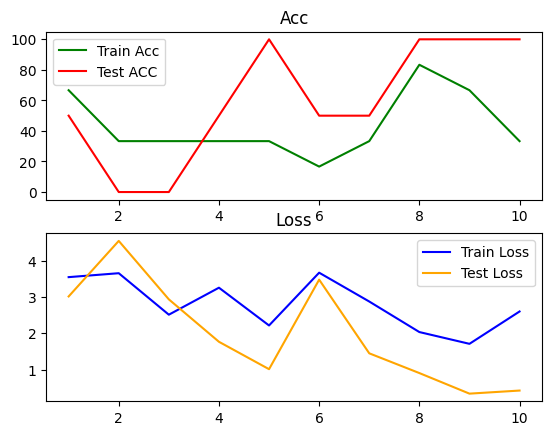

In [ ]:
optimizer = torch.optim.SGD(Model_ShuffleNet_V2_X2_0.parameters(),
                              lr=0.01)
train_loss_values_Model_ShuffleNet_V2_X2_0, train_acc_values_Model_ShuffleNet_V2_X2_0, test_loss_values_Model_ShuffleNet_V2_X2_0, test_acc_values_Model_ShuffleNet_V2_X2_0, train_epoch_count_Model_ShuffleNet_V2_X2_0, test_epoch_count_Model_ShuffleNet_V2_X2_0 = train_model(
    model=Model_ShuffleNet_V2_X2_0, train_dataloader=train_dataloader, test_dataloader=test_dataloader,
            optimizer=optimizer, loss_fn=loss_fn ,accuracy_fn=accuracy_fn, epochs=10, device=device)

plots(train_loss_values_Model_ShuffleNet_V2_X2_0, train_acc_values_Model_ShuffleNet_V2_X2_0, test_loss_values_Model_ShuffleNet_V2_X2_0, test_acc_values_Model_ShuffleNet_V2_X2_0, train_epoch_count_Model_ShuffleNet_V2_X2_0, test_epoch_count_Model_ShuffleNet_V2_X2_0)

In [ ]:
torch.save(Model_ShuffleNet_V2_X2_0, "/content/models/Model_ShuffleNet_V2_X2_0.pth")

In [ ]:
MODEL_PATH_BOBA_Model_ShuffleNet_V2_X2_0 = Path("E:/CODING/projectBoBa/transfer_models")
MODEL_NAME_BOBA_Model_ShuffleNet_V2_X2_0 = "BOBA_Model_ShuffleNet_V2_X2_0_dict.pth"
MODEL_PATH_BOBA_Model_ShuffleNet_V2_X2_0 / MODEL_NAME_BOBA_Model_ShuffleNet_V2_X2_0
save_model(Model_ShuffleNet_V2_X2_0, MODEL_PATH_BOBA_Model_ShuffleNet_V2_X2_0, MODEL_NAME_BOBA_Model_ShuffleNet_V2_X2_0)

RuntimeError: Parent directory E:/CODING/projectBoBa/transfer_models does not exist.

# swin_v2_b

In [10]:
Swin_V2_B_Weights = models.Swin_V2_B_Weights.DEFAULT
auto_transform = Swin_V2_B_Weights.transforms()

train_data = Food101(root="data/train",
                     split="train",
                     download=True,
                     transform=                  auto_transform)
test_data = Food101(root="data/test",
                     split="test",
                     download=True,
                     transform=                  auto_transform)

cpu_c = os.cpu_count()
BATCH_SIZE = 32
train_dataloader, test_dataloader, classes_names = make_data(train_data, test_data, batch_size=BATCH_SIZE, num_workers=cpu_c)
train_dataloader, test_dataloader, classes_names[:10], auto_transform

100%|██████████| 5.00G/5.00G [01:03<00:00, 79.2MB/s]
100%|██████████| 5.00G/5.00G [00:47<00:00, 106MB/s] 


(<torch.utils.data.dataloader.DataLoader at 0x7b6b7c8d4150>,
 ['apple_pie',
  'baby_back_ribs',
  'baklava',
  'beef_carpaccio',
  'beef_tartare',
  'beet_salad',
  'beignets',
  'bibimbap',
  'bread_pudding',
  'breakfast_burrito'],
 ImageClassification(
     crop_size=[256]
     resize_size=[272]
     mean=[0.485, 0.456, 0.406]
     std=[0.229, 0.224, 0.225]
     interpolation=InterpolationMode.BICUBIC
 ))

In [ ]:
Model_Swin_V2_B = models.swin_v2_b(weights=Swin_V2_B_Weights).to(device)
Model_Swin_V2_B

SwinTransformer(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (1): Permute()
      (2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (1): Sequential(
      (0): SwinTransformerBlockV2(
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (attn): ShiftedWindowAttentionV2(
          (qkv): Linear(in_features=128, out_features=384, bias=True)
          (proj): Linear(in_features=128, out_features=128, bias=True)
          (cpb_mlp): Sequential(
            (0): Linear(in_features=2, out_features=512, bias=True)
            (1): ReLU(inplace=True)
            (2): Linear(in_features=512, out_features=4, bias=False)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (0): Linear(in_features=128, out_features=512, bias=True)
          (1): GELU(appro

In [13]:
Model_Swin_V2_B = torch.load("/content/old_model/Model_Swin_V2_B_10ep.pth", weights_only=False).to(device)
Model_Swin_V2_B

SwinTransformer(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (1): Permute()
      (2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (1): Sequential(
      (0): SwinTransformerBlockV2(
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (attn): ShiftedWindowAttentionV2(
          (qkv): Linear(in_features=128, out_features=384, bias=True)
          (proj): Linear(in_features=128, out_features=128, bias=True)
          (cpb_mlp): Sequential(
            (0): Linear(in_features=2, out_features=512, bias=True)
            (1): ReLU(inplace=True)
            (2): Linear(in_features=512, out_features=4, bias=False)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (0): Linear(in_features=128, out_features=512, bias=True)
          (1): GELU(appro

In [14]:
summary(model=Model_Swin_V2_B,input_size=(32, 3, 256, 256),col_names=['input_size', 'output_size',"num_params", 'trainable'],col_width=20,row_settings=['var_names'])

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
SwinTransformer (SwinTransformer)                       [32, 3, 256, 256]    [32, 101]            --                   Partial
├─Sequential (features)                                 [32, 3, 256, 256]    [32, 8, 8, 1024]     --                   False
│    └─Sequential (0)                                   [32, 3, 256, 256]    [32, 64, 64, 128]    --                   False
│    │    └─Conv2d (0)                                  [32, 3, 256, 256]    [32, 128, 64, 64]    (6,272)              False
│    │    └─Permute (1)                                 [32, 128, 64, 64]    [32, 64, 64, 128]    --                   --
│    │    └─LayerNorm (2)                               [32, 64, 64, 128]    [32, 64, 64, 128]    (256)                False
│    └─Sequential (1)                                   [32, 64, 64, 128]    [32, 64, 64, 128]    --                   Fal

In [ ]:
Model_Swin_V2_B

SwinTransformer(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (1): Permute()
      (2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (1): Sequential(
      (0): SwinTransformerBlockV2(
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (attn): ShiftedWindowAttentionV2(
          (qkv): Linear(in_features=128, out_features=384, bias=True)
          (proj): Linear(in_features=128, out_features=128, bias=True)
          (cpb_mlp): Sequential(
            (0): Linear(in_features=2, out_features=512, bias=True)
            (1): ReLU(inplace=True)
            (2): Linear(in_features=512, out_features=4, bias=False)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (0): Linear(in_features=128, out_features=512, bias=True)
          (1): GELU(appro

In [ ]:
Model_Swin_V2_B.head = nn.Linear(in_features=1024, out_features=101, bias=True).to(device)
Model_Swin_V2_B

SwinTransformer(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (1): Permute()
      (2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (1): Sequential(
      (0): SwinTransformerBlockV2(
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (attn): ShiftedWindowAttentionV2(
          (qkv): Linear(in_features=128, out_features=384, bias=True)
          (proj): Linear(in_features=128, out_features=128, bias=True)
          (cpb_mlp): Sequential(
            (0): Linear(in_features=2, out_features=512, bias=True)
            (1): ReLU(inplace=True)
            (2): Linear(in_features=512, out_features=4, bias=False)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (0): Linear(in_features=128, out_features=512, bias=True)
          (1): GELU(appro

In [ ]:
Model_Swin_V2_B

SwinTransformer(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (1): Permute()
      (2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (1): Sequential(
      (0): SwinTransformerBlockV2(
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (attn): ShiftedWindowAttentionV2(
          (qkv): Linear(in_features=128, out_features=384, bias=True)
          (proj): Linear(in_features=128, out_features=128, bias=True)
          (cpb_mlp): Sequential(
            (0): Linear(in_features=2, out_features=512, bias=True)
            (1): ReLU(inplace=True)
            (2): Linear(in_features=512, out_features=4, bias=False)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (0): Linear(in_features=128, out_features=512, bias=True)
          (1): GELU(appro

In [ ]:
summary(model=Model_Swin_V2_B,input_size=(32, 3, 256, 256),col_names=['input_size', 'output_size',"num_params", 'trainable'],col_width=20,row_settings=['var_names'])

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
SwinTransformer (SwinTransformer)                       [32, 3, 256, 256]    [32, 101]            --                   Partial
├─Sequential (features)                                 [32, 3, 256, 256]    [32, 8, 8, 1024]     --                   False
│    └─Sequential (0)                                   [32, 3, 256, 256]    [32, 64, 64, 128]    --                   False
│    │    └─Conv2d (0)                                  [32, 3, 256, 256]    [32, 128, 64, 64]    (6,272)              False
│    │    └─Permute (1)                                 [32, 128, 64, 64]    [32, 64, 64, 128]    --                   --
│    │    └─LayerNorm (2)                               [32, 64, 64, 128]    [32, 64, 64, 128]    (256)                False
│    └─Sequential (1)                                   [32, 64, 64, 128]    [32, 64, 64, 128]    --                   Fal

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | Batch: 0...
Epoch: 1 | Batch: 400...
Epoch: 1 | Batch: 800...
Epoch: 1 | Batch: 1200...
Epoch: 1 | Batch: 1600...
Epoch: 1 | Batch: 2000...
Epoch: 1 | Loss: 1.3082 | Acc: 66.76%
TEST :    Epoch: 1 | Batch: 0...
TEST :    Epoch: 1 | Batch: 300...
TEST :    Epoch: 1 | Batch: 600...
TEST :    Epoch: 1 | Loss: 1.0321 | Acc: 73.33%


Epoch: 2 | Batch: 0...
Epoch: 2 | Batch: 400...
Epoch: 2 | Batch: 800...
Epoch: 2 | Batch: 1200...
Epoch: 2 | Batch: 1600...
Epoch: 2 | Batch: 2000...
Epoch: 2 | Loss: 1.2865 | Acc: 67.28%
TEST :    Epoch: 2 | Batch: 0...
TEST :    Epoch: 2 | Batch: 300...
TEST :    Epoch: 2 | Batch: 600...
TEST :    Epoch: 2 | Loss: 1.0165 | Acc: 73.73%


Epoch: 3 | Batch: 0...
Epoch: 3 | Batch: 400...
Epoch: 3 | Batch: 800...
Epoch: 3 | Batch: 1200...
Epoch: 3 | Batch: 1600...
Epoch: 3 | Batch: 2000...
Epoch: 3 | Loss: 1.2699 | Acc: 67.63%
TEST :    Epoch: 3 | Batch: 0...
TEST :    Epoch: 3 | Batch: 300...
TEST :    Epoch: 3 | Batch: 600...
TEST :    Epoch: 3 | Los

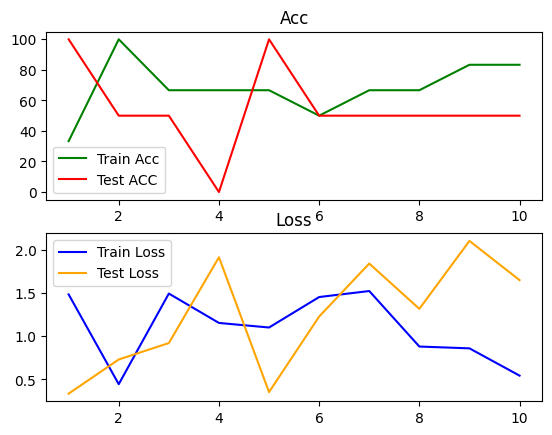

In [15]:
optimizer = torch.optim.SGD(Model_Swin_V2_B.parameters(),
                              lr=0.01)
train_loss_values_Model_Swin_V2_B, train_acc_values_Model_Swin_V2_B, test_loss_values_Model_Swin_V2_B, test_acc_values_Model_Swin_V2_B, train_epoch_count_Model_Swin_V2_B, test_epoch_count_Model_Swin_V2_B = train_model(
    model=Model_Swin_V2_B, train_dataloader=train_dataloader, test_dataloader=test_dataloader,
            optimizer=optimizer, loss_fn=loss_fn ,accuracy_fn=accuracy_fn, epochs=10, device=device)

plots(train_loss_values_Model_Swin_V2_B, train_acc_values_Model_Swin_V2_B, test_loss_values_Model_Swin_V2_B, test_acc_values_Model_Swin_V2_B, train_epoch_count_Model_Swin_V2_B, test_epoch_count_Model_Swin_V2_B)

In [16]:
torch.save(Model_Swin_V2_B, "/content/new_model/Model_Swin_V2_B_20ep.pth")